<a href="https://colab.research.google.com/github/Vakhranev/Compling/blob/master/%D0%A1%D0%B2%D1%91%D1%80%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D0%B5_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!unzip data.zip

Archive:  data.zip
replace quora.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
!pip install pandas scikit-learn matplotlib

In [0]:
import tensorflow as tf

In [0]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
quora = pd.read_csv('quora.csv')

In [0]:
vocab = Counter()

for sym in quora.question_text:
    sym = sym.lower()
    vocab.update(sym)

In [9]:
len(vocab)

1949

In [0]:
filtered_vocab = set()

for sym in vocab:
    if vocab[sym] > 5:
        filtered_vocab.add(sym)

In [11]:
len(filtered_vocab)

413

In [0]:
sym2id = {'UNK':1, 'PAD':0}

for sym in filtered_vocab:
    sym2id[sym] = len(sym2id)

In [0]:
id2sym = {i:sym for sym, i in sym2id.items()}

In [0]:
X = []

for text in quora.question_text:
    text = text.lower()
    ids = [sym2id.get(sym, 1) for sym in text]
    X.append(ids)

In [0]:
MAX_LEN = max(len(x) for x in X)

In [0]:
MEAN_LEN = np.median([len(x) for x in X])

In [17]:
MAX_LEN, MEAN_LEN

(1017, 60.0)

In [0]:
MAX_LEN = 65

In [0]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [53]:
X.shape

(1306122, 65)

In [0]:
y = quora.target.values

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

In [0]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.weights', 
                                                monitor='val_f1',
                                                verbose=1,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                mode='max',
                                                save_freq='epoch'
                                               )

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_f1', 
                                              min_delta=0.01,
                                              patience=20,
                                              verbose=1, 
                                              mode='max',
                                              )

In [0]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))

embeddings = tf.keras.layers.Embedding(input_dim=len(sym2id), output_dim=10)(inputs)
drop1 = tf.keras.layers.Dropout(0.3)(embeddings)
conv1 = tf.keras.layers.Conv1D(kernel_size=16, filters=128, strides=1, 
                                               kernel_regularizer='l2',
                                              activation='relu')(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=32, filters=128, strides=2, 
                                               kernel_regularizer='l2',
                                              activation='relu')(conv1)

drop2 = tf.keras.layers.Dropout(0.5)(conv2)

flatten = tf.keras.layers.Flatten()(drop2)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [0]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
          epochs=10,
          callbacks=[checkpoint, early_stop])

Epoch 1/10
621/621 [==============================] - ETA: 0s - loss: 0.2484 - f1: 2.4966e-05
Epoch 00001: val_f1 improved from -inf to 0.00000, saving model to model.weights
621/621 [==============================] - 340s 548ms/step - loss: 0.2484 - f1: 2.4966e-05 - val_loss: 0.2113 - val_f1: 0.0000e+00
Epoch 2/10
621/621 [==============================] - ETA: 0s - loss: 0.2054 - f1: 0.0000e+00
Epoch 00002: val_f1 did not improve from 0.00000
621/621 [==============================] - 337s 542ms/step - loss: 0.2054 - f1: 0.0000e+00 - val_loss: 0.1991 - val_f1: 0.0000e+00
Epoch 3/10
621/621 [==============================] - ETA: 0s - loss: 0.1946 - f1: 0.0000e+00
Epoch 00003: val_f1 did not improve from 0.00000
621/621 [==============================] - 335s 539ms/step - loss: 0.1946 - f1: 0.0000e+00 - val_loss: 0.1905 - val_f1: 0.0000e+00
Epoch 4/10
621/621 [==============================] - ETA: 0s - loss: 0.1871 - f1: 0.0366
Epoch 00004: val_f1 improved from 0.00000 to 0.08279, sa

In [0]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))

embeddings = tf.keras.layers.Embedding(input_dim=len(sym2id), output_dim=10)(inputs)
conv1 = tf.keras.layers.Conv1D(kernel_size=16, filters=128, strides=1, kernel_regularizer='l2', activation='relu')(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=32, filters=128, strides=2, kernel_regularizer='l2', activation='relu')(conv1)
pool1 = tf.keras.layers.AveragePooling1D()(conv2)
drop1 = tf.keras.layers.Dropout(0.1)(pool1)
conv3 = tf.keras.layers.Conv1D(kernel_size=8, filters=32)(embeddings)
conv4 = tf.keras.layers.Conv1D(kernel_size=16, filters=32, strides=1)(conv3)
conv5 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, activation='relu')(conv4)
pool2 = tf.keras.layers.AveragePooling1D()(conv5)
conv6 = tf.keras.layers.Conv1D(kernel_size=4, filters=32, strides=2)(embeddings)
conv7 = tf.keras.layers.Conv1D(kernel_size=16, filters=32, strides=2, activation='relu')(conv6)
conv8 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, kernel_regularizer='l2')(conv7)
drop2 = tf.keras.layers.Dropout(0.2)(conv8)
conv9 = tf.keras.layers.Conv1D(kernel_size=16, filters=32, strides=1, kernel_regularizer='l2', activation='relu')(embeddings)
conv10 = tf.keras.layers.Conv1D(kernel_size=16, filters=32, padding='same',strides=1)(conv9)
conv11 = tf.keras.layers.Conv1D(kernel_size=8, filters=16, strides=3)(conv10)
conv12 = tf.keras.layers.Conv1D(kernel_size=3, filters=8, strides=2)(conv11)
drop3 = tf.keras.layers.Dropout(0.3)(conv12)

flatten = tf.keras.layers.Flatten()(drop3)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [61]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
          epochs=40,
          callbacks=[checkpoint, early_stop])

Epoch 1/40
621/621 [==============================] - ETA: 0s - loss: 0.2335 - f1: 1.6528e-04
Epoch 00001: val_f1 did not improve from 0.34825
621/621 [==============================] - 11s 18ms/step - loss: 0.2335 - f1: 1.6528e-04 - val_loss: 0.2025 - val_f1: 9.8064e-04
Epoch 2/40
621/621 [==============================] - ETA: 0s - loss: 0.1959 - f1: 0.0575
Epoch 00002: val_f1 did not improve from 0.34825
621/621 [==============================] - 10s 16ms/step - loss: 0.1959 - f1: 0.0575 - val_loss: 0.1920 - val_f1: 0.1139
Epoch 3/40
620/621 [============================>.] - ETA: 0s - loss: 0.1859 - f1: 0.1680
Epoch 00003: val_f1 did not improve from 0.34825
621/621 [==============================] - 10s 16ms/step - loss: 0.1859 - f1: 0.1681 - val_loss: 0.1813 - val_f1: 0.1699
Epoch 4/40
621/621 [==============================] - ETA: 0s - loss: 0.1812 - f1: 0.2090
Epoch 00004: val_f1 did not improve from 0.34825
621/621 [==============================] - 10s 16ms/step - loss: 0.18

In [62]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 65)]              0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 65, 10)            4150      
_________________________________________________________________
conv1d_181 (Conv1D)          (None, 50, 32)            5152      
_________________________________________________________________
conv1d_182 (Conv1D)          (None, 50, 32)            16416     
_________________________________________________________________
conv1d_183 (Conv1D)          (None, 15, 16)            4112      
_________________________________________________________________
conv1d_184 (Conv1D)          (None, 7, 8)              392       
_________________________________________________________________
dropout_42 (Dropout)         (None, 7, 8)              0   

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


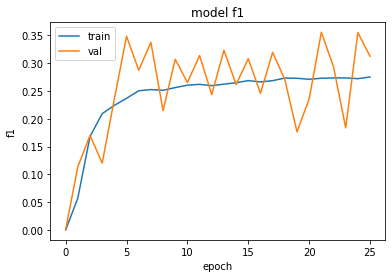

In [63]:
print(model.history.history.keys())
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()